# Dataset

- `utils.get_dataset`

$$
\begin{aligned}
    &\mathbf{u} \cdot \nabla \mathbf{u}+\nabla p-\frac{1}{R e} \nabla^2 \mathbf{u}&=0, \quad  (x,y) \in (0,1)^2, \\
    &\nabla \cdot \mathbf{u}&=0, \quad  (x,y) \in (0,1)^2, \\\\
\end{aligned}
$$

- solution
$$
\begin{aligned}
    &\mathbf{u} = (u, v) \\
    &u = u(x, y) \\
    &v = v(x, y)
\end{aligned}
$$

- u : x-component of velocity
- v : y-component of velocity
- p : pressure

- BC

    - top : $\mathbf{u}=(1, 0)$
    - others : non-slip boundary condition $\mathbf{u}=\mathbf{0}$

In [22]:
import os

In [23]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [24]:
from utils import get_dataset

In [25]:
Re = 1000
u_ref, v_ref, x_star, y_star, nu = get_dataset(Re)

In [26]:
print(u_ref.shape)
print(v_ref.shape)
print(x_star.shape)
print(y_star.shape)
print(nu)

(128, 128)
(128, 128)
(128,)
(128,)
[[0.001]]


# Data visualization

In [27]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from eval import x_Ghia, y_Ghia, u_Ghia, v_Ghia

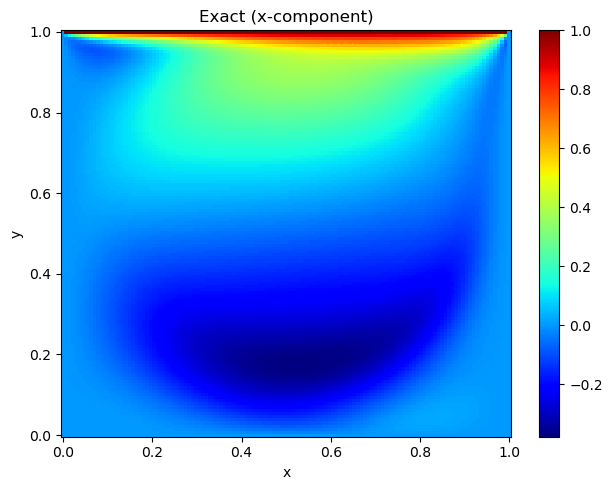

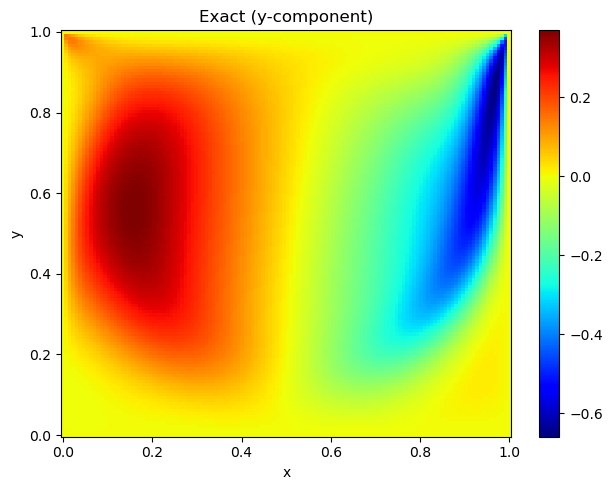

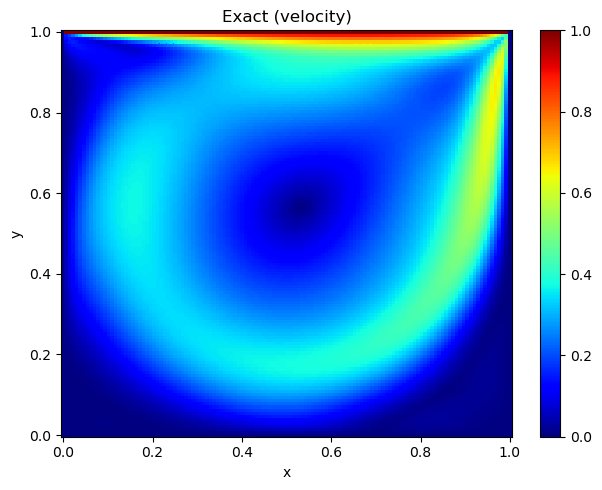

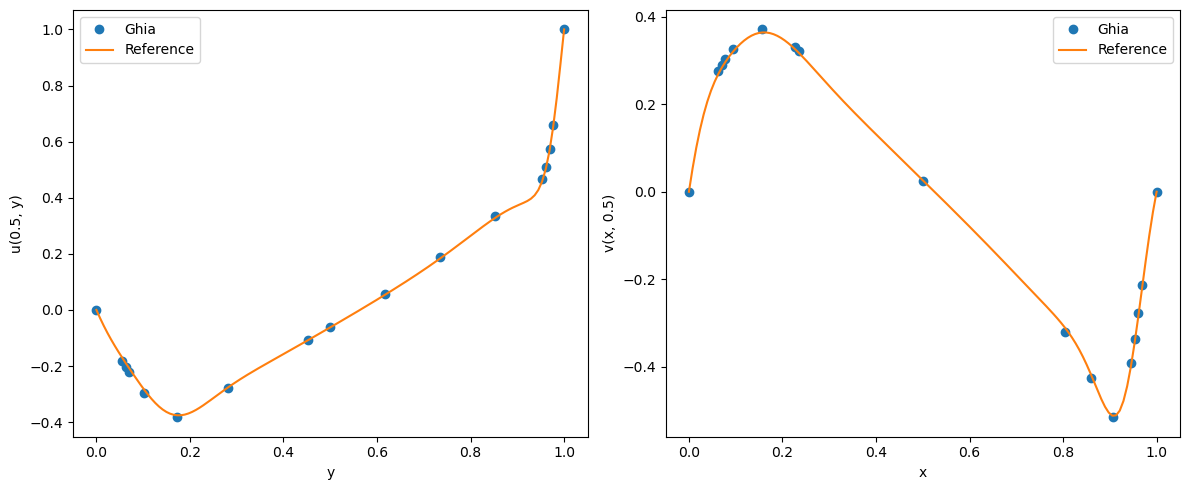

In [28]:
XX, YY = jnp.meshgrid(x_star, y_star, indexing="ij")

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, u_ref, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact (x-component)")
plt.tight_layout()

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, v_ref, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact (y-component)")
plt.tight_layout()


fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, jnp.sqrt(u_ref**2+v_ref**2), cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact (velocity)")
plt.tight_layout()

n_x, n_y = u_ref.shape

fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_Ghia, u_Ghia[Re], "o", label="Ghia")
plt.plot(y_star, u_ref[n_x // 2, :], label="Reference")
plt.xlabel("y")
plt.ylabel("u(0.5, y)")
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(x_Ghia, v_Ghia[Re], "o", label="Ghia")
plt.plot(x_star, v_ref[:, n_y // 2], label="Reference")
plt.xlabel("x")
plt.ylabel("v(x, 0.5)")
plt.legend()
plt.tight_layout()

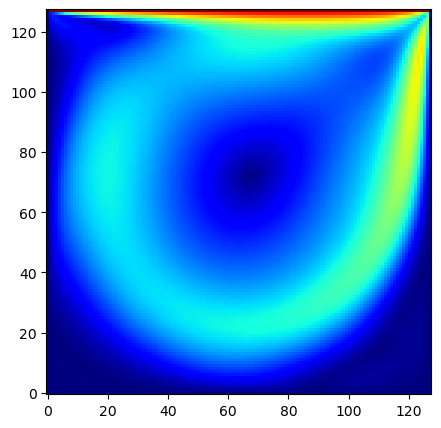

In [31]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.imshow(jnp.sqrt(u_ref**2+v_ref**2).T, cmap="jet", origin='lower')

# Model

In [8]:
import jax.numpy as jnp
from jax import vmap

from jaxpi.models import ForwardBVP

In [9]:
class NavierStokes2D(ForwardBVP):
    def __init__(self, config):
        super().__init__(config)

        self.u_pred_fn = vmap(vmap(self.u_net, (None, None, 0)), (None, 0, None))
        self.v_pred_fn = vmap(vmap(self.v_net, (None, None, 0)), (None, 0, None))

    def neural_net(self, params, x, y):
        z = jnp.stack([x, y])
        outputs = self.state.apply_fn(params, z)
        u = outputs[0]
        v = outputs[1]
        p = outputs[2]
        return u, v, p

    def u_net(self, params, x, y):
        u, _, _ = self.neural_net(params, x, y)
        return u
    
    def v_net(self, params, x, y):
        _, v, _ = self.neural_net(params, x, y)
        return v

    def p_net(self, params, x, y):
        _, _, p = self.neural_net(params, x, y)
        return p

In [10]:
workdir = "."
from configs import plain
config = plain.get_config()

import os
from jaxpi.utils import save_checkpoint, restore_checkpoint

In [11]:
model = NavierStokes2D(config)

ckpt_path = os.path.abspath(os.path.join(workdir, "ckpt", config.wandb.name))
save_checkpoint(model.state, ckpt_path, keep=config.saving.num_keep_ckpts, overwrite=True)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

In [12]:
u_pred = model.u_pred_fn(params, x_star, y_star)
v_pred = model.v_pred_fn(params, x_star, y_star)

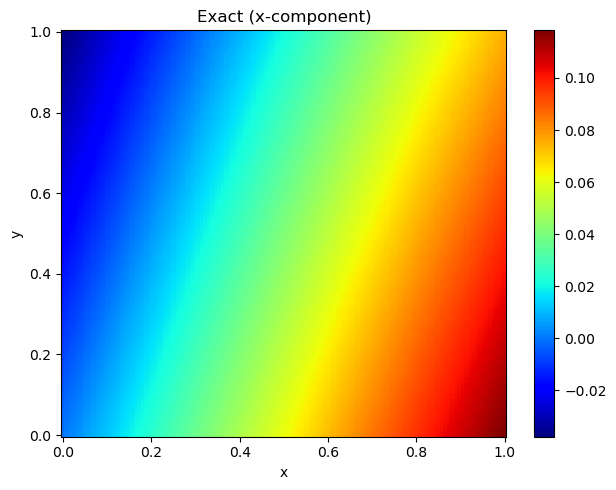

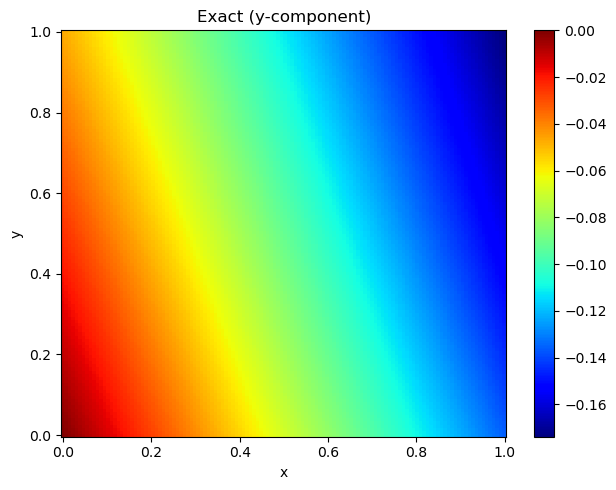

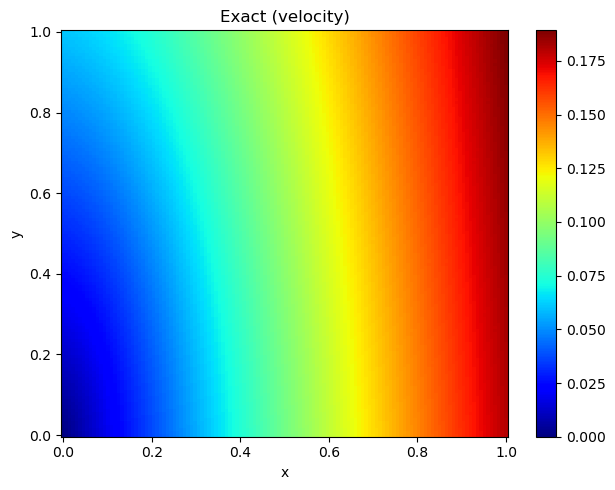

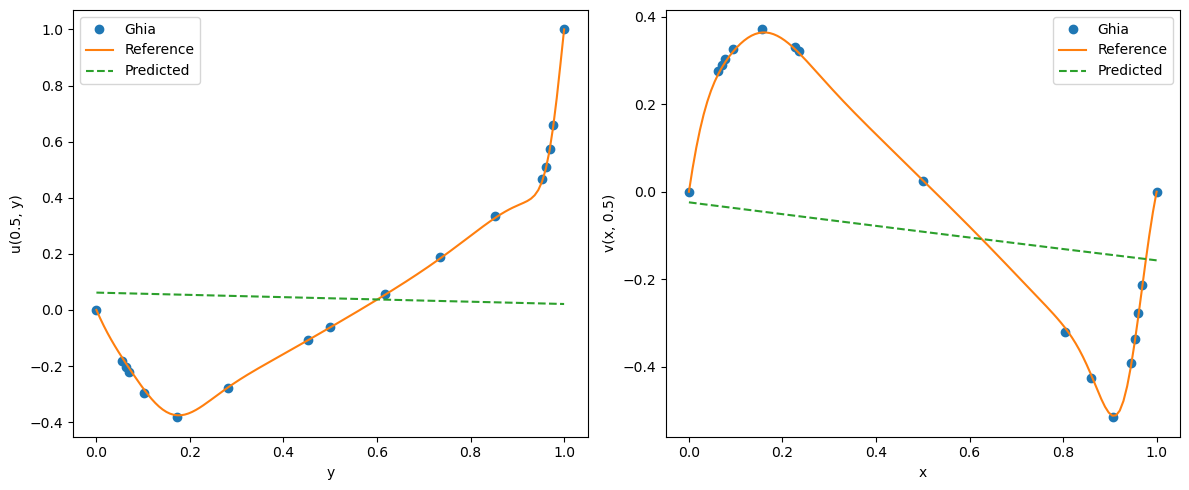

In [13]:
XX, YY = jnp.meshgrid(x_star, y_star, indexing="ij")

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, u_pred, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact (x-component)")
plt.tight_layout()

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, v_pred, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact (y-component)")
plt.tight_layout()


fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, jnp.sqrt(u_pred**2+v_pred**2), cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact (velocity)")
plt.tight_layout()

n_x, n_y = u_pred.shape

fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_Ghia, u_Ghia[Re], "o", label="Ghia")
plt.plot(y_star, u_ref[n_x // 2, :], label="Reference")
plt.plot(y_star, u_pred[n_x // 2, :], '--', label="Predicted")
plt.xlabel("y")
plt.ylabel("u(0.5, y)")
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(x_Ghia, v_Ghia[Re], "o", label="Ghia")
plt.plot(x_star, v_ref[:, n_y // 2], label="Reference")
plt.plot(x_star, v_pred[:, n_y // 2], '--', label="Predicted")
plt.xlabel("x")
plt.ylabel("v(x, 0.5)")
plt.legend()
plt.tight_layout()

# Residual net

In [14]:
from functools import partial

import jax.numpy as jnp
from jax import lax, jit, grad, vmap, pmap, jacrev, hessian

from jaxpi.models import ForwardBVP

from utils import sample_points_on_square_boundary

In [15]:
num_pts_per_side = 256
points = sample_points_on_square_boundary(num_pts_per_side, eps=0.01)
print(points.shape)
print(points)

(1024, 2)
[[0.         1.        ]
 [0.00392157 1.        ]
 [0.00784314 1.        ]
 ...
 [1.         0.9822354 ]
 [1.         0.9861177 ]
 [1.         0.99      ]]


In [16]:
v_bc = jnp.zeros((num_pts_per_side * 4,))
print(v_bc.shape)
print(v_bc)

(1024,)
[0. 0. 0. ... 0. 0. 0.]


In [17]:
u_bc = v_bc.at[:num_pts_per_side].set(1.0)
print(u_bc.shape)
print(u_bc)

(1024,)
[1. 1. 1. ... 0. 0. 0.]


In [18]:
class NavierStokes2D(ForwardBVP):
    def __init__(self, config):
        super().__init__(config)

        # Sample boundary points uniformly
        # [top, bottom, left, right]
        num_pts_per_side = 256
        self.x_bc1 = sample_points_on_square_boundary(num_pts_per_side, eps=0.01)
        self.x_bc2 = sample_points_on_square_boundary(num_pts_per_side, eps=0.01)

        # Boundary conditions
        self.v_bc = jnp.zeros((num_pts_per_side * 4,))
        self.u_bc = self.v_bc.at[:num_pts_per_side].set(1.0)

        # Predictions over a grid
        self.u_pred_fn = vmap(vmap(self.u_net, (None, None, 0)), (None, 0, None))
        self.v_pred_fn = vmap(vmap(self.v_net, (None, None, 0)), (None, 0, None))
        self.p_pred_fn = vmap(vmap(self.p_net, (None, None, 0)), (None, 0, None))
        self.r_pred_fn = vmap(self.r_net, (None, None, 0, 0))

    def neural_net(self, params, x, y):
        z = jnp.stack([x, y])
        outputs = self.state.apply_fn(params, z)
        u = outputs[0]
        v = outputs[1]
        p = outputs[2]
        return u, v, p

    def u_net(self, params, x, y):
        u, _, _ = self.neural_net(params, x, y)
        return u
    
    def v_net(self, params, x, y):
        _, v, _ = self.neural_net(params, x, y)
        return v

    def p_net(self, params, x, y):
        _, _, p = self.neural_net(params, x, y)
        return p
    
    # def r_net(self, params, nu, x, y):
    #     u, v, p = self.neural_net(params, x, y)

    #     (u_x, u_y), (v_x, v_y), (p_x, p_y) = jacrev(self.neural_net, argnums=(1, 2))(params, x, y)

    #     u_hessian = hessian(self.u_net, argnums=(1, 2))(params, x, y)
    #     v_hessian = hessian(self.v_net, argnums=(1, 2))(params, x, y)

    #     u_xx = u_hessian[0][0]
    #     u_yy = u_hessian[1][1]

    #     v_xx = v_hessian[0][0]
    #     v_yy = v_hessian[1][1]

    #     ru = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    #     rv = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
    #     rc = u_x + v_y

    #     return ru, rv, rc

    def r_net(self, params, nu, x, y):
        u, v, p = self.neural_net(params, x, y)

        u_x = grad(self.u_net, argnums=1)(params, x, y)
        u_y = grad(self.u_net, argnums=2)(params, x, y)

        v_x = grad(self.v_net, argnums=1)(params, x, y)
        v_y = grad(self.v_net, argnums=2)(params, x, y)

        p_x = grad(self.p_net, argnums=1)(params, x, y)
        p_y = grad(self.p_net, argnums=2)(params, x, y)

        u_xx = grad(grad(self.u_net, argnums=1), argnums=1)(params, x, y)
        u_yy = grad(grad(self.u_net, argnums=2), argnums=2)(params, x, y)

        v_xx = grad(grad(self.v_net, argnums=1), argnums=1)(params, x, y)
        v_yy = grad(grad(self.v_net, argnums=2), argnums=2)(params, x, y)

        ru = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        rv = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
        rc = u_x + v_y

        return ru, rv, rc
    
    def ru_net(self, params, nu, x, y):
        ru, _, _ = self.r_net(params, nu, x, y)
        return ru

    def rv_net(self, params, nu, x, y):
        _, rv, _ = self.r_net(params, nu, x, y)
        return rv

    def rc_net(self, params, nu, x, y):
        _, _, rc = self.r_net(params, nu, x, y)
        return rc
    
    @partial(jit, static_argnums=(0,))
    def losses(self, params, batch, nu):
        # boundary condition losses
        # Compute forward pass of u and v
        u_pred = self.u_pred_fn(params, self.x_bc1[:, 0], self.x_bc1[:, 1])
        v_pred = self.v_pred_fn(params, self.x_bc2[:, 0], self.x_bc2[:, 1])

        # Compute losses
        u_bc_loss = jnp.mean((u_pred - self.u_bc) ** 2)
        v_bc_loss = jnp.mean((v_pred - self.v_bc)**2)

        # Compute forward pass of residual
        ru_pred, rv_pred, rc_pred = self.r_pred_fn(params, nu, batch[:, 0], batch[:, 1])
        # Compute losses
        ru_loss = jnp.mean(ru_pred**2)
        rv_loss = jnp.mean(rv_pred**2)
        rc_loss = jnp.mean(rc_pred**2)

        loss_dict = {
            "u_bc": u_bc_loss,
            "v_bc": v_bc_loss,
            "ru": ru_loss,
            "rv": rv_loss,
            "rc": rc_loss,
        }

        return loss_dict
    

    @partial(pmap, axis_name="batch", static_broadcasted_argnums=(0, 3))
    def step(self, state, batch, nu):
        grads = grad(self.loss)(state.params, state.weights, batch, nu)
        grads = lax.pmean(grads, "batch")
        state = state.apply_gradients(grads=grads)
        return state

In [19]:
import jax
from jax.tree_util import tree_map
from jax import jacrev
import seaborn as sns

from jaxpi.utils import flatten_pytree
from jaxpi.samplers import UniformSampler

In [20]:
workdir = "."
from configs import plain
config = plain.get_config()

model = NavierStokes2D(config)

# Get dataset
u_ref, v_ref, x_star, y_star, nu = get_dataset(Re)
U_ref = jnp.sqrt(u_ref**2 + v_ref**2)
# Update viscosity
nu = 1 / Re

x0 = x_star[0]
x1 = x_star[-1]

y0 = y_star[0]
y1 = y_star[-1]

# Define domain
dom = jnp.array([[x0, x1], [y0, y1]])

# Define domain
dom = jnp.array([[x0, x1], [y0, y1]])

# Initialize  residual sampler
res_sampler = iter(UniformSampler(dom, 1024))

In [21]:
batch = next(res_sampler)
model.state = model.step(model.state, batch, nu)

2023-12-29 19:06:39.187518: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.09GiB (rounded to 9762667264)requested by op 
2023-12-29 19:06:39.187618: W external/tsl/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2023-12-29 19:06:39.188478: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 9762667160 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.28MiB
              constant allocation:    12.1KiB
        maybe_live_out allocation:    2.28MiB
     preallocated temp allocation:    9.09GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    9.10GiB
Peak buffers:
	Buffer 1:
		Size: 1.01GiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 9762667160 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.28MiB
              constant allocation:    12.1KiB
        maybe_live_out allocation:    2.28MiB
     preallocated temp allocation:    9.09GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    9.10GiB
Peak buffers:
	Buffer 1:
		Size: 1.01GiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(jvp(Mlp))/Dense_0/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=121
		XLA Label: custom-call
		Shape: f32[1059840,256]
		==========================

	Buffer 2:
		Size: 1.01GiB
		Operator: op_name="pmap(step)/jit(main)/transpose(jvp(jit(loss)))/jit(losses)/vmap(transpose(vmap(jvp(jvp(Mlp)))))/Dense_0/dot_general[dimension_numbers=(((1,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=121
		XLA Label: custom-call
		Shape: f32[1058816,256]
		==========================

	Buffer 3:
		Size: 1.00GiB
		Operator: op_name="pmap(step)/jit(main)/transpose(jvp(jit(loss)))/jit(losses)/vmap(vmap(Mlp))/Dense_2/reduce_sum[axes=(0, 1)]" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=121 deduplicated_name="fusion.546"
		XLA Label: fusion
		Shape: f32[1024,1024,256]
		==========================

	Buffer 4:
		Size: 1.00GiB
		Operator: op_name="pmap(step)/jit(main)/transpose(jvp(jit(loss)))/jit(losses)/vmap(vmap(Mlp))/Dense_3/dot_general[dimension_numbers=(((2,), (1,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=121
		XLA Label: custom-call
		Shape: f32[1048576,256]
		==========================

	Buffer 5:
		Size: 1.00GiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(vmap(Mlp))/Dense_2/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=121 deduplicated_name="triton_gemm_dot.830"
		XLA Label: fusion
		Shape: f32[1048576,256]
		==========================

	Buffer 6:
		Size: 1.00GiB
		Operator: op_name="pmap(step)/jit(main)/transpose(jvp(jit(loss)))/jit(losses)/vmap(vmap(Mlp))/Dense_3/dot_general[dimension_numbers=(((2,), (1,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=121
		XLA Label: custom-call
		Shape: f32[1048576,256]
		==========================

	Buffer 7:
		Size: 1.00GiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(vmap(Mlp))/Dense_2/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=121 deduplicated_name="triton_gemm_dot.830"
		XLA Label: fusion
		Shape: f32[1048576,256]
		==========================

	Buffer 8:
		Size: 1.00GiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(vmap(Mlp))/Dense_1/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=121 deduplicated_name="triton_gemm_dot.830"
		XLA Label: fusion
		Shape: f32[1048576,256]
		==========================

	Buffer 9:
		Size: 1.00GiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(vmap(Mlp))/Dense_1/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=float32]" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=121 deduplicated_name="triton_gemm_dot.830"
		XLA Label: fusion
		Shape: f32[1048576,256]
		==========================

	Buffer 10:
		Size: 1.00MiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(transpose(vmap(jvp(jvp(Mlp)))))/add_any" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=152
		XLA Label: fusion
		Shape: f32[1024,256]
		==========================

	Buffer 11:
		Size: 1.00MiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(transpose(vmap(jvp(jvp(Mlp)))))/add_any" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=152
		XLA Label: fusion
		Shape: f32[1024,256]
		==========================

	Buffer 12:
		Size: 1.00MiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(transpose(vmap(jvp(jvp(Mlp)))))/add_any" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=152
		XLA Label: fusion
		Shape: f32[1024,256]
		==========================

	Buffer 13:
		Size: 1.00MiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(transpose(vmap(jvp(jvp(Mlp)))))/add_any" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=152
		XLA Label: fusion
		Shape: f32[1024,256]
		==========================

	Buffer 14:
		Size: 1.00MiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(transpose(vmap(jvp(jvp(Mlp)))))/add_any" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=152
		XLA Label: fusion
		Shape: f32[1024,256]
		==========================

	Buffer 15:
		Size: 1.00MiB
		Operator: op_name="pmap(step)/jit(main)/jvp(jit(loss))/jit(losses)/vmap(transpose(vmap(jvp(jvp(Mlp)))))/add_any" source_file="/home/usr/workspace/jaxpi/jaxpi/archs.py" source_line=152
		XLA Label: fusion
		Shape: f32[1024,256]
		==========================



In [ ]:
ckpt_path = os.path.abspath(os.path.join(workdir, "ckpt", config.wandb.name))
save_checkpoint(model.state, ckpt_path, keep=config.saving.num_keep_ckpts, overwrite=True)
model.state = restore_checkpoint(model.state, ckpt_path)
params = model.state.params

u_pred = model.u_pred_fn(params, x_star, y_star)
v_pred = model.v_pred_fn(params, x_star, y_star)

XX, YY = jnp.meshgrid(x_star, y_star, indexing="ij")

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, u_ref, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact (x-component)")
plt.tight_layout()

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, v_ref, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact (y-component)")
plt.tight_layout()


fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, jnp.sqrt(u_ref**2+v_ref**2), cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Exact (velocity)")
plt.tight_layout()

n_x, n_y = u_ref.shape

fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(y_Ghia, u_Ghia[Re], "o", label="Ghia")
plt.plot(y_star, u_ref[n_x // 2, :], label="Reference")
plt.xlabel("y")
plt.ylabel("u(0.5, y)")
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(x_Ghia, v_Ghia[Re], "o", label="Ghia")
plt.plot(x_star, v_ref[:, n_y // 2], label="Reference")
plt.xlabel("x")
plt.ylabel("v(x, 0.5)")
plt.legend()
plt.tight_layout()